# Testing Navier-Stokes with a body in package `ViscousFlow`

In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [3]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body. Here is a plate:

In [4]:
n = 51;
body = Bodies.Plate(1.0,n)

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [5]:
n = 50;
body = Bodies.NACA4(0.0,0.0,0.15,np=n)

NACA 4-digit airfoil with 99 points and length 1.0 and thickness 0.15
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


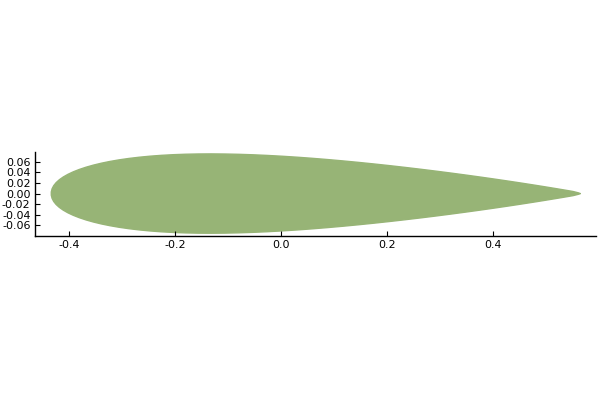

In [6]:
plot(body)

Transform the body with a specified initial position and orientation.

In [7]:
cent = (0.0,0.0) #1.0+1.0im
α = -π/4 #-π/3 #-π/4
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

NACA 4-digit airfoil with 99 points and length 1.0 and thickness 0.15
   Current position: (0.0,0.0)
   Current angle (rad): -0.7853981633974483


Set up the domain

In [8]:
xlim = (-1.0,3.0)
ylim = (-1.0,1.0)

(-1.0, 1.0)

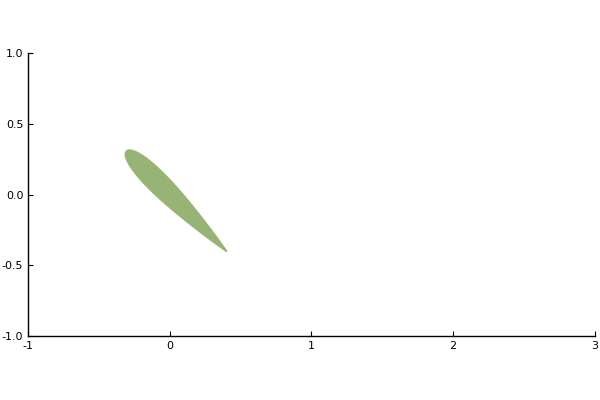

In [9]:
plot(body,xlim=xlim,ylim=ylim)

Now set up the coordinate data for operator construction

In [10]:
X = VectorData(body.x,body.y);

Set the domain size and time step size

In [11]:
Δx = 0.02;
Δt = min(0.5*Δx,0.5*Δx^2*Re);

### Now set up the system

Set up the state vector and constraint force vector for a static body

In [12]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 202 x 102

In [13]:
w₀ = Nodes(Dual,size(sys));
f = VectorData(X);
xg, yg = coordinates(w₀,dx=Δx,I0=Systems.origin(sys))

(-1.01:0.02:3.0100000000000002, -1.01:0.02:1.01)

Set up the integrator here

In [14]:
@time ifherk = IFHERK(w₀,f,sys.Δt,
                (t,u) -> Systems.plan_intfact(t,u,sys),
                (u,t) -> TimeMarching.plan_constraints(u,t,sys),
                ((u,t) -> Systems.r₁(u,t,sys),
                 (u,t) -> Systems.r₂(u,t,sys)),rk=TimeMarching.RK31,isstored=true)

  7.104325 seconds (12.55 M allocations: 1.075 GiB, 6.31% gc time)


Order-3 IF-HERK integrator with
   State of type Nodes{Dual,202,102}
   Force of type VectorData{99}
   Time step size 0.01


Initialize the state vector and the history vectors

In [15]:
t = 0.0
w₀ .= 0.0
u = deepcopy(w₀)

fx = Float64[];
fy = Float64[];
thist = Float64[];

uhist = [];
tsample = 0.2; # rate at which to store field data

### Advance the system!

Set the time range to integrate over.

In [16]:
tf = 3.0;
T = Δt:Δt:tf;

In [17]:
for ti in T
    global t, u, f = ifherk(t,u)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-6) || isapprox(mod(t,tsample),tsample,atol=1e-6)) ? push!(uhist,u) : nothing
end
println("solution completed through time t = ",t)

solution completed through time t = 2.99999999999998


#### Plotting

Basic plot

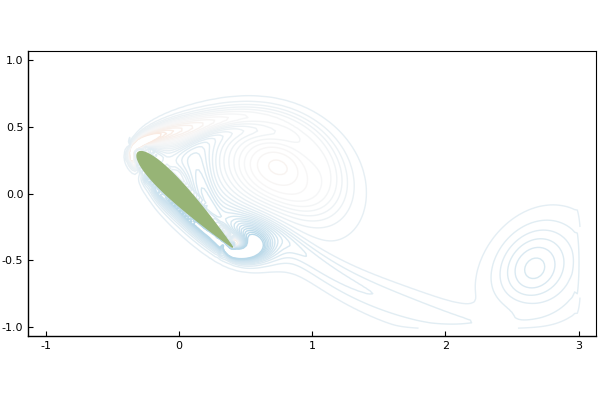

In [18]:
plot(xg,yg,uhist[end],levels=range(-0.25,stop=0.25,length=30), color = :RdBu)
plot!(body)

Make a movie

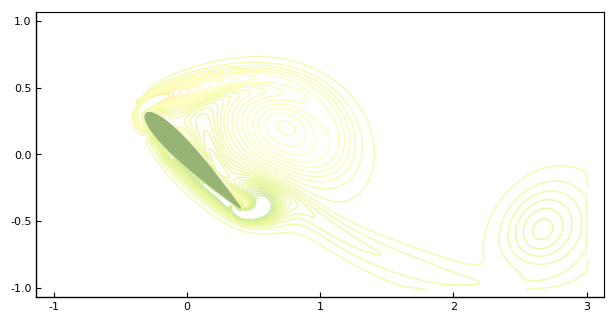

┌ Info: Saved animation to 
│   fn = /Users/jeff/ViscousFlow/examples/tmp.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/qh1wV/src/animation.jl:90


Plots.AnimatedGif("/Users/jeff/ViscousFlow/examples/tmp.gif")

In [19]:
@gif for i = 1:length(uhist)
    plot(xg,yg,uhist[i],levels=range(-0.25,stop=0.25,length=30))
    plot!(body)
end

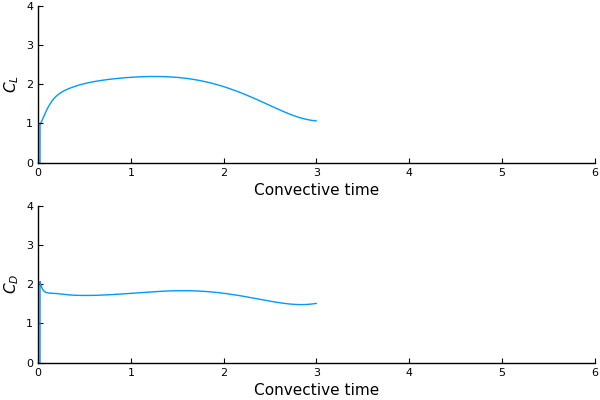

In [20]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],thist,2*fy,xlim=(0,6),ylim=(0,4),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],thist,2*fx,xlim=(0,6),ylim=(0,4),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt

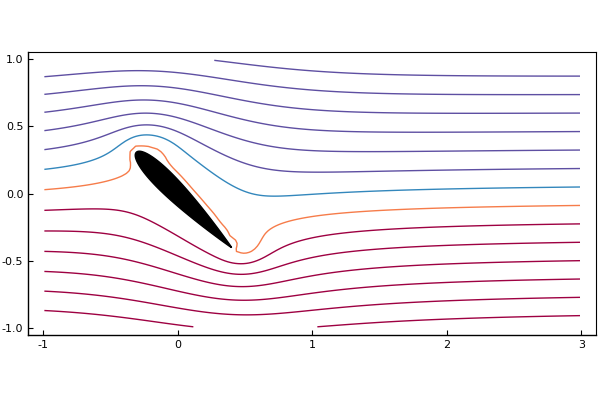

In [21]:
xg,yg = coordinates(u,dx=Δx,I0=Systems.origin(sys))
ψ = deepcopy(uhist[end])
ψ .= -(sys.L\uhist[1])*Δx .+ repeat(collect(yg)',size(sys,1),1)
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)